In [1]:
%matplotlib inline
%pylab
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%config InlineBackend.figure_format='retina'

import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

from Xana import Xana
from Xana.misc.makemask import masker
from matplotlib.colors import LogNorm
from Xana import Soq

from glob import glob
from Xana import CorrFunc
from Xana.Xfit.fitg2global import G2
from Xana.Xfit.fit_basic import fit_basic
from Xana.misc.add_colorbar import add_colorbar
import configparser

import pandas as pd
import pickle
import h5py

import sys
sys.path.insert(0, '../06-scripts/')
# import plots as pl
from plots import *

Using matplotlib backend: <object object at 0x2b609ea6d8d0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
pwd

'/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/01-notebooks'

In [3]:
ls ../06-scripts

plots.py  __pycache__/  xana_tools.py


# Functions

In [5]:
def plot_ttcs(ind_xpcs, vmin=None, vmax=None):
    """This functions plots the two-time correlation functions.
    
    Args:
        ind_xpcs (int): database index.
        vmin (float): minimum of colormap passed to imshow.
        vmax (flaot): maximum of colormap passed to imshow.
    
    """
    ana = d
    tmp = ana.get_item(ind_xpcs)

    ttcs = tmp['twotime_corf'] # list from 0 to 20: len=21
    ttcxy = tmp['twotime_xy'] # shape (5000,)
    del tmp

    nttcs = len(ttcs.keys()) # 21: number of qs or rois
    nttcs = (nttcs // 2) * 2 # 20

    # shape qv_phi:  (21, 2)
    nq = len(np.unique(qv_phi[:nttcs,0])) # 20
    nangles = len(np.unique(qv_phi[:nttcs,1])) # 1

    condition = nq <= nangles # False

    ncols = 5
    nrows = nq // ncols #nq if condition else nangles #1
    #ncols = nangles if condition else nq #20

    fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows), constrained_layout=True)
    axs = np.array(axs)
    axs = np.ravel(axs.T) if condition else np.ravel(axs)

    for i, (ind, a) in enumerate(zip(ttcs.keys(), axs)):
        #print(i, ind, a, axs)
        im = a.imshow(ttcs[ind], origin='lower', cmap='inferno', 
                      extent=[ttcxy[0], ttcxy[-1]]*2, vmin=vmin, vmax=vmax)
        q, angle = qv_phi[i]
        a.set_title(f'$q={q:.3f}\,\mathrm{{nm}}^{{-1}}$', fontsize=8)
        a.set_xlabel('$t_1\,(\mathrm{s})$', size=10)
        a.set_xlabel('$t_2\,(\mathrm{s})$', size=10)
        #if ((i < 2) and not condition) or (condition and i % ncols == 0):
        if i in [0,5]:
            cb = plt.colorbar(im, ax=a, shrink=.8, aspect=50,)
            cb.ax.tick_params(labelsize=8) 
        a.minorticks_on()
        a.tick_params(which='major', labelsize=8)


def plot_many_qs(ana, nq, nangles, qv_phi, qv, phi, rescale=False):
    """Create a plot when a setup was used with only 2 angles and several q-bins.
    """
    # Now we use the CorrFunc module
    g = CorrFunc(ana)

    fig, axs = plt.subplots(3, 2, figsize=(6,8), constrained_layout=True, sharex='row', sharey='row')
    axs = np.array(axs).T

    angles_per_q = np.unique(qv, return_counts=True)[1]
    xf = np.logspace(-2,1,100)

    i0 = 0
    for i, (p, ax) in enumerate(zip(phi, axs)):

        a = ax[0]    
        g.get_g2(ind_xpcs, merge='merge')
        g.nq = np.where(np.isclose(qv_phi[:,1], p))[0]
        qv = qv_phi[g.nq, 0]
        if rescale:
            g.rescale(0, interval=(6,-6), norm_contrast=True)
        g.plot_g2(doplot='data_legq_fit', color_mode=1, dofit=1, 
                  cmap='viridis', data='rescaled',
                  ax=a, markersize=5, method='equal',
                  init={"t0":(2, None, None)},
    #               fitglobal=['g0'],
                  fix={"a":1,})

        display(g.pars[0])

        #a.set_title(f'$\phi={p:.0f}\,\mathrm{{deg}}$')

        a = ax[1]
        angles = qv_phi[g.nq,1]
        a.errorbar(qv, 1/g.pars[0]['t0'], yerr=1/g.pars[0]['t0']**2*g.pars[0]['dt0'], fmt='o', color='tab:blue')
    #     a.set_ylim(0,10)
        a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
        a.set_ylabel(r'$\Gamma_0\,(\mathrm{s}^{-1})$')

        a = ax[2]
        angles = qv_phi[g.nq,1]
        a.errorbar(qv, g.pars[0]['g0'], yerr=g.pars[0]['dg0'], fmt='o', color='tab:red')
        a.set_ylim(0,3)
        a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
        a.set_ylabel(r'$\alpha$')

    for i, a in enumerate(axs.flatten()):
        a.minorticks_on()
        a.tick_params(which='both', right=True, top=True)
        if i//3:
            a.set_ylabel('')
            

# Elog

In [6]:
elog = pd.read_pickle("../02-sources/elog")

In [7]:
elog.columns

Index(['Run n', 'Sample', 'Sample no. (label)', 'folder', 'scan number',
       'Short comment', 'cooling rate (K/min)', 'Target temperature (K)',
       'Detector', 'Beam size (um)', '# Si absorber (25um each)',
       'transmission', 'Exposure time per frame (s)', 'number of frames',
       'Total exposure time (s)', 'Mesh (spots x lines)', 'comments'],
      dtype='object')

In [8]:
elog[(elog['folder'].str.contains('HydLys_0p25_2', na=False))
    #& (elog['# Si absorber (25um each)']==6) 
    ]

,Run n,Sample,Sample no. (label),folder,scan number,Short comment,cooling rate (K/min),Target temperature (K),Detector,Beam size (um),# Si absorber (25um each),transmission,Exposure time per frame (s),number of frames,Total exposure time (s),Mesh (spots x lines),comments
555,446,hyd lys h0.25,1.1,HydLys_0p25_2_00001,NaN,"fluences, changed beam size!",NaN,290,NaN,30x30,0.0,NaN,"0,5",2000.0,1000,NaN,NaN
556,447,hyd lys h0.25,1.1,HydLys_0p25_2_00002,NaN,fluences,NaN,290,NaN,30x30,3.0,NaN,"0,5",2000.0,1000,NaN,NaN
557,448,hyd lys h0.25,1.1,HydLys_0p25_2_00003,NaN,fluences,NaN,290,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
558,449,hyd lys h0.25,1.1,HydLys_0p25_2_00004,NaN,fluences,NaN,290,NaN,30x30,9.0,NaN,"0,5",2000.0,1000,NaN,NaN
559,450,hyd lys h0.25,1.1,HydLys_0p25_2_00005,NaN,temperatures epseries,NaN,280,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
560,451,hyd lys h0.25,1.1,HydLys_0p25_2_00006,NaN,temperatures epseries,NaN,270,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
561,452,hyd lys h0.25,1.1,HydLys_0p25_2_00007,NaN,temperatures epseries,NaN,260,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
562,453,hyd lys h0.25,1.1,HydLys_0p25_2_00008,NaN,temperatures epseries,NaN,250,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
563,454,hyd lys h0.25,1.1,HydLys_0p25_2_00009,NaN,temperatures epseries,NaN,240,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN
564,455,hyd lys h0.25,1.1,HydLys_0p25_2_00010,NaN,temperatures epseries,NaN,230,NaN,30x30,6.0,NaN,"0,5",2000.0,1000,NaN,NaN


# Measurement details

In [9]:
d = Xana()
d.load_db('../05-analysis-fluences/analysis_database.pkl')

Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-fluences/analysis_database.pkl
Successfully loaded database


In [10]:
sample = 'HydLys_0p25_2'

## Select

In [11]:
display(d.db[d.db['sample']==sample])

,use,sample,analysis,series,subset,t_delay,t_exposure,t_readout,nframes,first,last,master,datdir,mod,savname,savfile,setupfile,comment
0,True,HydLys_0p25_2,xpcs,1,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 16:24:15.937770,s0001_0000.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
1,True,HydLys_0p25_2,saxs,1,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 16:25:57.902979,s0001_0001.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
2,True,HydLys_0p25_2,xpcs,2,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 16:40:55.129457,s0002_0002.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
3,True,HydLys_0p25_2,saxs,2,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 16:42:26.641259,s0002_0003.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
4,True,HydLys_0p25_2,xpcs,3,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 17:10:29.539415,s0003_0004.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
5,True,HydLys_0p25_2,saxs,3,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 17:11:49.677618,s0003_0005.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
6,True,HydLys_0p25_2,xpcs,4,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-19 13:29:26.986582,s0004_0006.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
7,True,HydLys_0p25_2,saxs,4,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-19 13:30:18.127084,s0004_0007.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,


In [12]:
inds_xpcs = d.db[(d.db['sample'] == sample) 
           & (d.db['analysis']=='xpcs')].index.values

display(d.db.loc[inds_xpcs])

,use,sample,analysis,series,subset,t_delay,t_exposure,t_readout,nframes,first,last,master,datdir,mod,savname,savfile,setupfile,comment
0,True,HydLys_0p25_2,xpcs,1,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 16:24:15.937770,s0001_0000.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
2,True,HydLys_0p25_2,xpcs,2,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 16:40:55.129457,s0002_0002.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
4,True,HydLys_0p25_2,xpcs,3,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-18 17:10:29.539415,s0003_0004.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,
6,True,HydLys_0p25_2,xpcs,4,0,0.503,0.5,0.00001,1990,10,1999,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,/asap3/petra3/gpfs/p10/2022/data/11014696/raw/...,2022-10-19 13:29:26.986582,s0004_0006.pkl,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,/asap3/petra3/gpfs/p10/2022/data/11014696/proc...,


**Select and sort measurements**

In [13]:
series_n = d.db.loc[inds_xpcs, 'series'].values
inds_xpcs_sorted = [x for _,x in sorted(zip(series_n, inds_xpcs))]
inds_xpcs_sorted

[0, 2, 4, 6]

In [14]:
# ind_xpcs = ind_xpcs[0]
sample = d.db.loc[inds_xpcs_sorted, 'sample']

In [15]:
# sample

### Load setup

In [16]:
detector = 'eiger4m'
setupfile = d.db.loc[inds_xpcs_sorted[0], 'setupfile']

d = Xana(setupfile=setupfile)
d.load_db('../05-analysis-fluences/analysis_database.pkl')

Loaded setupfile:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/04-setups/setup-HydLys_0p25_2_00001_dbid00.pkl.
Try loading database:
	/asap3/petra3/gpfs/p10/2022/data/11014696/processed/maddalena/05-analysis-fluences/analysis_database.pkl
Successfully loaded database


### Show mask and rois

<IPython.core.display.Javascript object>


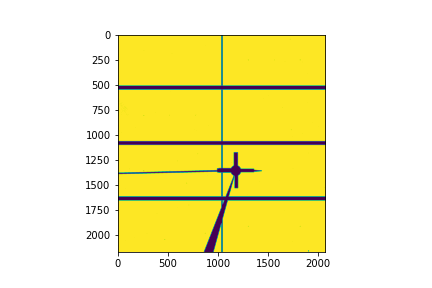

In [17]:
plt.figure()
plt.imshow(d.setup.mask);

In [18]:
phi = d.setup.phiv
print(f'angles array: {phi}')
phi = phi[:,0] + phi[:,1]/2
print(f'angles vector: {phi}')
qv = d.setup.qv
print(f'q-vector: {qv}')

qv_phi = np.zeros((len(qv), 2))
qv_phi[:,0] = qv
i0 = 0
for i1 in np.unique(qv, return_counts=True)[1]:
    qv_phi[i0:i0+i1,1] = phi[:i1]
    i0 += i1

nangles = len(phi) # number of unqiue angles
nq = len(np.unique(qv)) # number of unique q-values

angles array: [[-180.  360.]]
angles vector: [0.]
q-vector: [0.005 0.02  0.035 0.05  0.065 0.08  0.095 0.11  0.125 0.14  0.155 0.17
 0.185 0.2  ]


# Plot TTCs

<IPython.core.display.Javascript object>


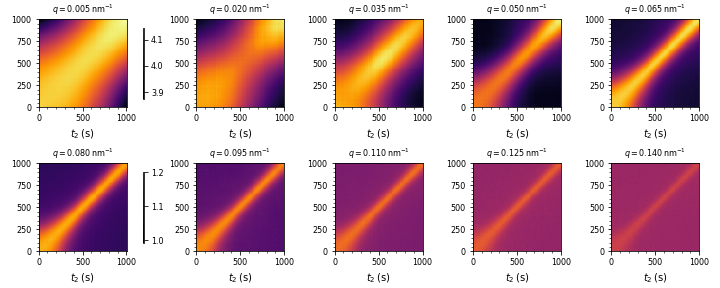

In [19]:
plot_ttcs(inds_xpcs_sorted[-1])#, vmin=None, vmax=None)
# fig.suptitle(f"{sample}_{run_series:05}")

**Plot all Qs**

In [21]:
Abs = [0,3,6,9]
len(Abs), len(inds_xpcs)

(4, 4)

Loaded 1 correlation functions.


<IPython.core.display.Javascript object>


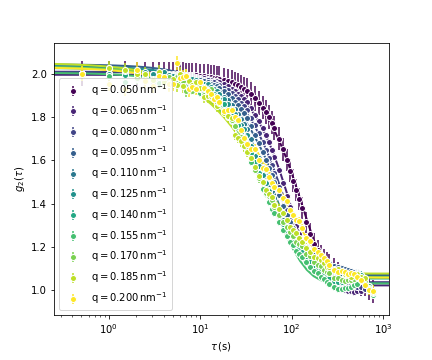

Fit successful: True


<IPython.core.display.Javascript object>


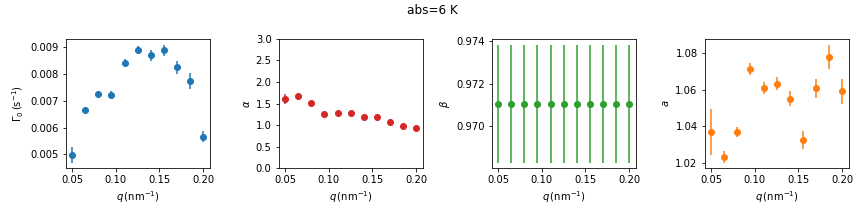

In [22]:
ind_sel = 2

g = CorrFunc(d)
g.get_g2(inds_xpcs_sorted[ind_sel], verbose=True)

# -- to limit time
# g.reset_rescaled()

tmp = g.corrFuncRescaled[0][0][:,0]
tmp = tmp < 8e2
g.corrFuncRescaled[0] = (g.corrFuncRescaled[0][0][tmp], # data
                         g.corrFuncRescaled[0][1][tmp]) # errorbars
del tmp

# # g.reset_rescaled()
g.rescale(interval=(1, -2), norm_contrast=1)

nq = np.arange(3,len(qv))
# nq = np.arange(2,12)
g.plot_g2(nq=nq, doplot='data_legq_fit', color_mode=1, dofit=1, fix={},
          init={'t0':(100,0,None), 'g0':(1, .1, 4), 'beta':(.2, 0, 1), 'a':(1,0,2)}, 
          fitglobal=['beta'], 
          verbose=True, cmap='viridis', title=f'{sample}')
# display(g.pars[0])

fig, (a1,a2,a3,a4) = plt.subplots(1, 4, figsize=(12,3), tight_layout=True)
fig.suptitle(f'abs={Abs[ind_sel]} K')
qvs = qv_phi[nq,0]
a = a1
qv_sel = qv[list(nq)]
# a.errorbar(qv_sel, 1/g.pars[0]['t0'], yerr=1/g.pars[0]['t0']**2*g.pars[0]['dt0'], fmt='o', color='tab:blue')
a.errorbar(qvs, 1/g.pars[0]['t0'], yerr=1/g.pars[0]['t0']**2*g.pars[0]['dt0'], fmt='o', color='tab:blue')
#     a.set_ylim(0,10)
a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
a.set_ylabel(r'$\Gamma_0\,(\mathrm{s}^{-1})$')

a = a2
a.errorbar(qv_sel, g.pars[0]['g0'], yerr=g.pars[0]['dg0'], fmt='o', color='tab:red')
a.set_ylim(0,3)
a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
a.set_ylabel(r'$\alpha$')

a = a3
a.errorbar(qv_sel, g.pars[0]['beta'], yerr=g.pars[0]['dbeta'], fmt='o', color='tab:green')
# a.set_ylim(0.7,1.3)
a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
a.set_ylabel(r'$\beta$')

a = a4
a.errorbar(qv_sel, g.pars[0]['a'], yerr=g.pars[0]['da'], fmt='o', color='tab:orange')
# a.set_ylim(0.7,1.3)
a.set_xlabel('$q\,(\mathrm{nm}^{-1})$')
a.set_ylabel(r'$a$')
fig.show()

# Plots fluences together

<IPython.core.display.Javascript object>


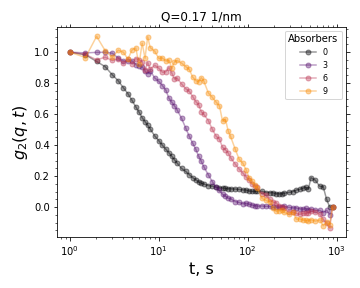

Loaded 1 correlation functions.
Loaded 1 correlation functions.
Loaded 1 correlation functions.
Loaded 1 correlation functions.


In [29]:
f, ax1 = plt.subplots(1,1,figsize=(5,4), tight_layout=True)
col = plt.cm.inferno(np.linspace(0,1,len(inds_xpcs_sorted)+1))
q_sel = 11

for i,ind in enumerate(inds_xpcs_sorted[:]):
    g = CorrFunc(d)
    g.get_g2(ind)
    
    t = g.corrFuncRescaled[0][0][1:,0]
    qv = g.corrFuncRescaled[0][0][0, 1:]
    g2 = g.corrFuncRescaled[0][0][1:,1:]
    
    y = g2[1:,q_sel] - g2[-1,q_sel]
    y /= y[0]
    plt.plot(t[1:], y, c=col[i], marker='o', ms=5, alpha=.4, ls='-', label=f'{Abs[i]}')

ax1.legend(title='Absorbers', ncol=1, fontsize=8)
ax1.set_xscale('log')
plt.xlabel('t, s', fontsize=16)
plt.ylabel(r'$g_2(q,t)$', fontsize=16)
ax1.set_title(f'Q={qv[q_sel]:.2f} 1/nm')
ax1.minorticks_on()
ax1.tick_params(which='both', right=True, top=True)
plt.show()

**g2s from ttcs**

In [24]:
def ttc_to_g2(ttc, time=None):
    """Calculate g2 function from TTC
    Args:
        cor (np.ndarray): sqaure correlation matrix (TTC)
        time (np.ndarray, optional): 1D vector of lag times. Defaults to None.
            If None, np.arange will be used for evenly spaced time bins.
    """
    ntimes = ttc.shape[0]
    if time is None:
        time = np.arange(ntimes) + 1

    # initialize output array
    g2 = np.ones((ntimes, 3))
    g2[:, 0] = time
    for i in range(1, ntimes):
        dia = np.diag(ttc, k=i)
        ind = np.where(np.isfinite(dia))
        if len(dia[ind]):
            g2[i - 1, 1] = np.mean(dia[ind])
            g2[i - 1, 2] = np.std(dia[ind])
    g2[:, 2] *= np.sqrt(1.0 / (ntimes))
    return g2

def calculate_g2(ttc):
    """Calculate the g2 function from a TTC
    """
    g2 = []
    for i in range(ttc.shape[0]):
        g2.append(np.diag(ttc, k=i).mean())
    return g2

<IPython.core.display.Javascript object>


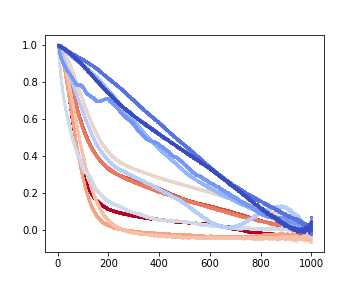

IndexError: index 12 is out of bounds for axis 0 with size 12

In [25]:
plt.figure(figsize=(5,4))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(T)))
j = 4
for i in range(len(ind_xpcs)):
    tmp = d.get_item(ind_xpcs[i])
    ttcs = tmp['twotime_corf'] # list from 0 to 20: len=21
    ttcxy = tmp['twotime_xy'] # shape (5000,)
    qv = tmp['qv']
    keys = list(ttcs.keys())
    del tmp

    ttc = ttcs[keys[j]]
    g2 = calculate_g2(ttc)
    t_lim = -1
#     g2 = ttc_to_g2(ttc, time=ttcxy)
    #print(g2.shape)
    y = (g2[:] - np.average(g2[-3:])) #/ g2[0]
    y /= y[0]
    
    plt.plot(ttcxy[:t_lim], y[:t_lim], marker='o', c=col[i], ms=2, fillstyle='none', ls='', label=f"{T[i]}")
    
plt.xscale('log')
plt.legend(title='T (K)', ncol=2, fontsize=8)
plt.xlabel('t, s')
plt.ylabel(r'$g_2(q,t)$')
plt.ylim(-.1,1.1)
plt.title(f'Q={qv[j]:.2f} 1/nm')
plt.tight_layout()

### One run

<IPython.core.display.Javascript object>


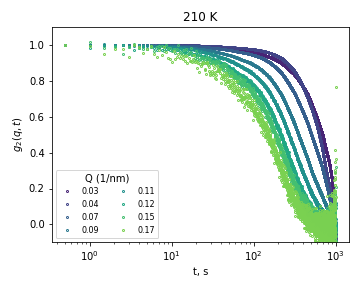

In [73]:
plt.figure(figsize=(5,4))
col = plt.cm.viridis(np.linspace(0,1,len(keys)))
T_sel = 8
tmp = d.get_item(ind_xpcs[T_sel])
ttcs = tmp['twotime_corf']
ttcxy = tmp['twotime_xy']
keys = list(ttcs.keys())
del tmp

for i in range(1,len(keys)-2):
    ttc = ttcs[keys[i]]
    tt = 2000
    g2 = calculate_g2(ttc[:tt,:tt])
    t_lim = -1
    #g2 = ttc_to_g2(ttc, time=ttcxy)
    #print(g2.shape)
    y = (g2[:] - np.average(g2[-100:-10])) #/ g2[0]
    y /= y[1]
    
    plt.plot(ttcxy[:tt], y[:], marker='o', c=col[i], ms=2, fillstyle='none', ls='', label=f"{qv[i]:.2f}")
#     plt.plot(g2[:-10,0], g2[:-10,1], marker='o', c=col[i], ms=2, fillstyle='none', ls='')
    
plt.xscale('log')
plt.title(f'{T[T_sel]} K')
plt.legend(title='Q (1/nm)', ncol=2, fontsize=8)
plt.xlabel('t, s')
plt.ylabel(r'$g_2(q,t)$')
plt.ylim(-.1,1.1)
plt.tight_layout()

### $\chi_4$ vs temperatures

<IPython.core.display.Javascript object>


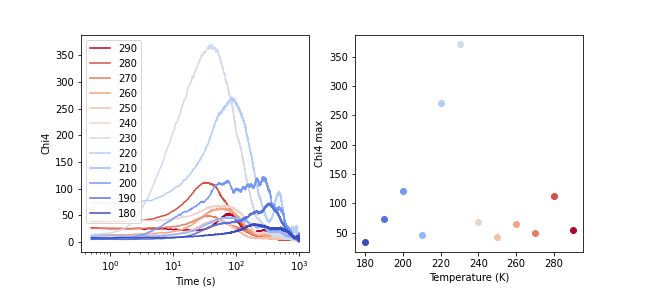

In [41]:
f, (a1,a2) = plt.subplots(1,2,figsize=(9,4))
col = plt.cm.coolwarm_r(np.linspace(0,1,len(inds_xpcs)))
q_sel = 4

for i,ind in enumerate(inds_xpcs):
    tmp = d.get_item(ind)
    chi4 = tmp['chi4']
    xtime = tmp['twotime_xy']
    
    del tmp
    a1.plot(xtime[1:-1], chi4[q_sel][:,0], c=col[i], label=T[i])
    a2.plot(T[i], np.max(chi4[q_sel][:,0]), ls='',marker='o', c=col[i])

a1.set_xscale('log')
a1.legend()
a1.set_xlabel('Time (s)')
a1.set_ylabel('Chi4')
a2.set_xlabel('Temperature (K)')
a2.set_ylabel('Chi4 max')
plt.show()
#tmp.keys()

In [26]:
g.reset_rescaled()
# g.rescale(interval=(1, -5), norm_contrast=1)
g.rescale(norm_contrast=1)

<IPython.core.display.Javascript object>


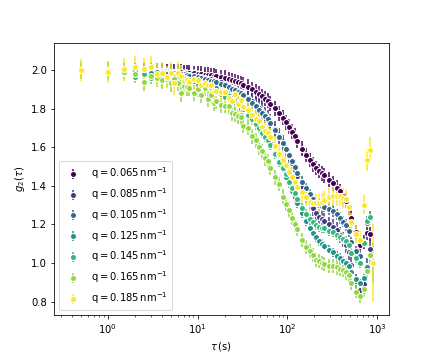

In [27]:
g.plot_g2(nq=np.arange(3,len(qv)-1),
          dofit=0, doplot='data_legq',color_mode=1,verbose=True,
          # change_marker=1,
          # data='rescaled',
           #fix={'beta': 0.13},
           init={'t0': (1e2, 0, 1e3),
                 'a': (1, 0, None),
                 'g0': (1.5, 0, 3),
                 'beta': (.1, 0, 4)
                }, 
#           fitglobal=['g0', 'a'], 
           cmap='viridis')
# ax.grid(ls=':')

# Manual g2s

**From Xana**

In [ ]:
g = CorrFunc(d)
g.get_g2(ind_xpcs)

In [ ]:
t = g.corrFunc[0][0][1:,0]
qv = g.corrFunc[0][0][0, 1:]
g2 = g.corrFunc[0][0][1:,1:]
# print(t.shape, qv.shape, g2.shape)
col = plt.cm.viridis(np.linspace(0,1,len(qv)))

plt.figure()
for q in range(len(qv)):
    y = g2[1:,q] - g2[-1,q]
    y /= y[0]
    plt.plot(t[1:], y, c=col[q])
plt.xscale('log')
plt.show()

**Calculated from TTCs**

In [ ]:
def ttc_to_g2(ttc, time=None):
    """Calculate g2 function from TTC
    Args:
        cor (np.ndarray): sqaure correlation matrix (TTC)
        time (np.ndarray, optional): 1D vector of lag times. Defaults to None.
            If None, np.arange will be used for evenly spaced time bins.
    """
    ntimes = ttc.shape[0]
    if time is None:
        time = np.arange(ntimes) + 1

    # initialize output array
    g2 = np.ones((ntimes, 3))
    g2[:, 0] = time
    for i in range(1, ntimes):
        dia = np.diag(ttc, k=i)
        ind = np.where(np.isfinite(dia))
        if len(dia[ind]):
            g2[i - 1, 1] = np.mean(dia[ind])
            g2[i - 1, 2] = np.std(dia[ind])
    g2[:, 2] *= np.sqrt(1.0 / (ntimes))
    return g2

def calculate_g2(ttc):
    """Calculate the g2 function from a TTC
    """
    g2 = []
    for i in range(ttc.shape[0]):
        g2.append(np.diag(ttc, k=i).mean())
    return g2

In [ ]:
tmp = d.get_item(ind_xpcs)
ttcs = tmp['twotime_corf'] # list from 0 to 20: len=21
ttcxy = tmp['twotime_xy'] # shape (5000,)
qv = tmp['qv']
del tmp

In [ ]:
plt.figure(figsize=(12,2))
nttcs = 5
for i in range(nttcs):
    plt.subplot(1,nttcs,1+i)
    plt.imshow(ttcs[i], origin='lower', cmap='inferno',extent=[ttcxy[0], ttcxy[-1]]*2)#, vmin=vmin, vmax=vmax)
    plt.colorbar(shrink=0.4)
    plt.title(f"Q={qv[i]:.2f} 1/nm")
plt.tight_layout()
plt.show()

In [ ]:
keys = list(ttcs.keys())

In [ ]:
plt.figure(figsize=(5,4))
col = plt.cm.viridis(np.linspace(0,1,len(keys)))

for i in range(len(keys)):
    ttc = ttcs[keys[i]]
    g2 = calculate_g2(ttc)
    t_lim = -100
    #g2 = ttc_to_g2(ttc, time=ttcxy)
    #print(g2.shape)
    y = (g2[:] - np.average(g2[-100:-10])) #/ g2[0]
    y /= y[0]
    
    plt.plot(ttcxy[:t_lim], y[:t_lim], marker='o', c=col[i], ms=2, fillstyle='none', ls='', label=f"{qv[i]:.2f}")
#     plt.plot(g2[:-10,0], g2[:-10,1], marker='o', c=col[i], ms=2, fillstyle='none', ls='')
    
plt.xscale('log')
plt.legend(title='Q (1/nm)', ncol=2, fontsize=8)
plt.xlabel('t, s')
plt.ylabel(r'$g_2(q,t)$')
plt.ylim(-.1,1.1)
plt.tight_layout()

# Trying the g2 from Mariia's code

Merged g2 functions:  [0.5] (exposure times)
                      [1] (number of correlation functions)
                      [2000] (total number of images)


<IPython.core.display.Javascript object>


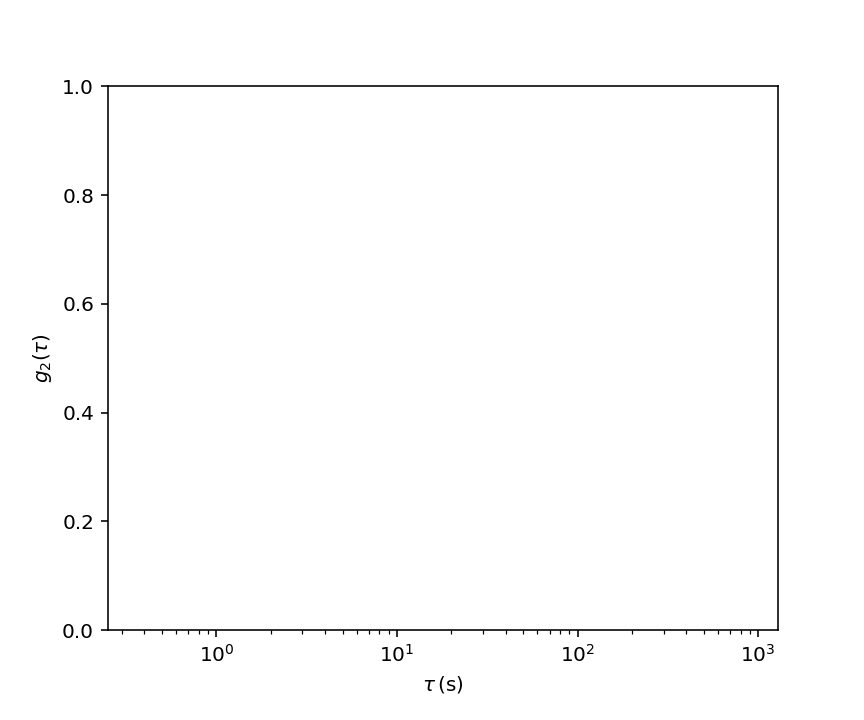

Fit successful: False


<IPython.core.display.Javascript object>


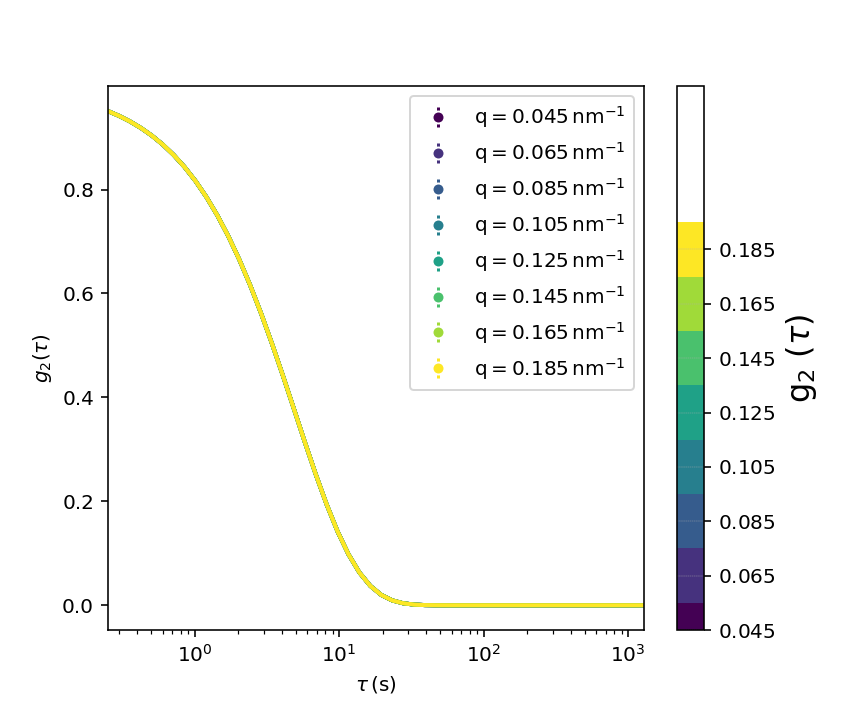

Fit successful: False


In [125]:
# -- initializing CorrFunc instance
g = CorrFunc(d)

# -- searching data base for xpcs measurements
#ind = ind_xpcs
#ind = ana.db[(ana.db['sample'] == sample2) 
#                       & (ana.db['series']==run_s) 
#                       & (ana.db['analysis']=='xpcs')].index.values


#print(pupa)


# -- loading correlation functions
g.get_g2(ind_xpcs, merge='merge')

# -- plotting
g.nq = np.arange(2,10)

g.rescale(0, interval=(6,-6), normby='average', norm_contrast=1, norm_baseline=False, baseline=1)

g.plot_g2(doplot='', dofit=1, fix={'a':1, 'beta':1}, cmap='viridis',  color_mode=0,
          init={'t0':(10,0, None), 'g0':(1, .1, None), 'beta':(1, 0, None)},
          #fitglobal=['g0','a'],  'beta'
         )

#g.rescale( normby='fit', norm_contrast=True, contrast=1, baseline=1)
#g.rescale(0, interval=(6,-6), normby='fit', norm_contrast=1, norm_baseline=True, baseline = 0)

lupa = list(g.corrFuncRescaled[0])
lupa[0][1:,1:]=lupa[0][1:,1:]-1
g.corrFuncRescaled[0] = lupa

g.plot_g2(doplot='data_legq_fit', dofit=1, fix={'a':0, 'beta':1}, cmap='viridis',  color_mode=1,
          init={'t0':(10,0, None), 'g0':(1, .1, None), 'beta':(1, 0, None)},
          #fitglobal=['g0','a'],  'beta'
          add_colorbar=True
         )


#plt.title(ana.db.loc[ind[-1], 'sample'])#, f'_{series:05}')


#plt.suptitle(f'{sample2}_{run_s:05}')
plt.ylim(0,10)
#plt.xlim(8e-3,1e0)
plt.xlabel(r'$\tau$ (s)',fontsize = 16)
plt.ylabel(r'g$_2$ ($\tau$)',fontsize = 16)
#plt.legend(ncol=2)#,bbox_to_anchor=(1.05, 1.0) )
plt.grid(ls='--', lw=0.2)

#axins = inset_axes(plt, width=1.3, height=0.9)

## Learning

In [33]:
g.rescale??

In [41]:
g.rescale(normby='average', norm_contrast=False, contrast=1, baseline=1)

<IPython.core.display.Javascript object>


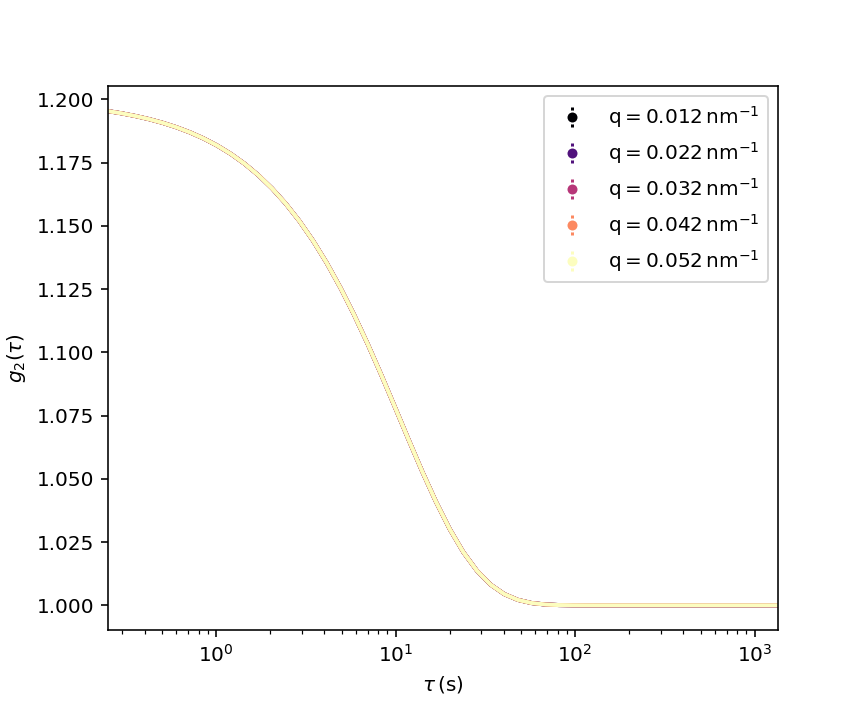

In [42]:
g.plot_g2(doplot='data_legq_fit', dofit=0)

In [61]:
g.get_g2(ind_xpcs, merge='merge') 

Merged g2 functions:  [0.5] (exposure times)
                      [1] (number of correlation functions)
                      [2000] (total number of images)


<IPython.core.display.Javascript object>


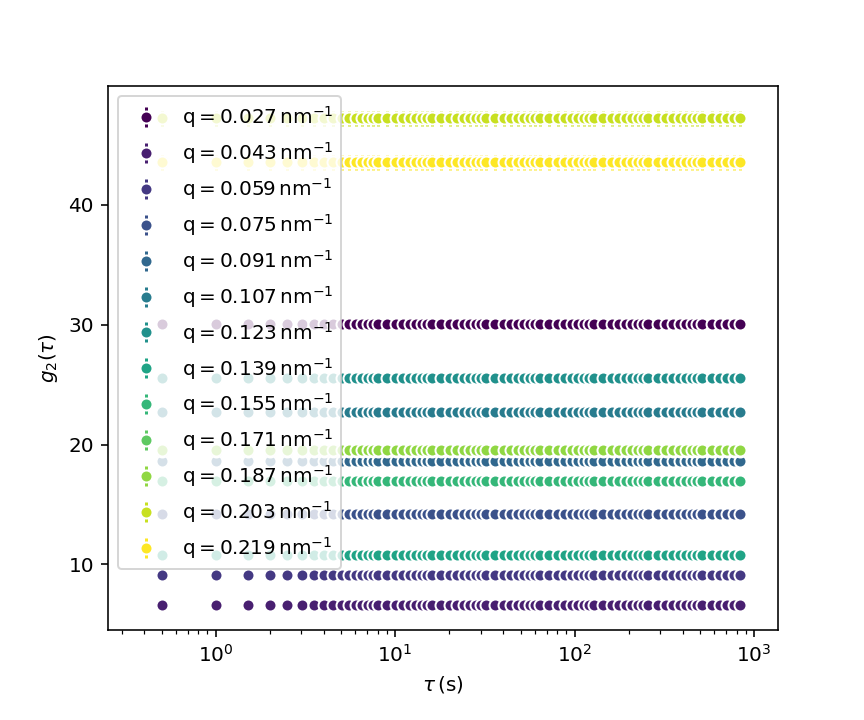

In [62]:
g.nq = np.arange(1,nq)

# the following is to fit only up to the first decay
tmp = g.corrFuncRescaled[0][0][:,0]
tmp = tmp<4e3 
g.corrFuncRescaled[0] = (g.corrFuncRescaled[0][0][tmp], # data
                         g.corrFuncRescaled[0][1][tmp]) # errorbars
del tmp

g.plot_g2(doplot='data_legq', color_mode=1, dofit=0, fix={}, 
          init={'t0':(t0_ini,0, None), 'g0':(1, .1, 4), 'beta':(.2, 0, 1.1)}, 
          #fitglobal=['g0'], #fitglobal=['g0','beta'], 
          verbose=True, cmap='viridis', title=f'{sample}')

In [116]:
display(g.pars[0])

,q,t0,dt0,g0,dg0,beta,dbeta,b0,db0,a,da,chisqr,redchi,bic,aic
0,0.022,118.729016,15.162958,1.172197,0.182755,0.324584,0.018558,0.324584,0.018558,1.305772,0.008936,1090.314421,0.786663,173.382943,-271.230542
1,0.032,87.652053,6.660530,1.041706,0.098420,0.320791,0.012544,0.320791,0.012544,1.167505,0.004617,1090.314421,0.786663,173.382943,-271.230542
2,0.042,67.482941,3.401171,0.973071,0.063636,0.305670,0.009120,0.305670,0.009120,1.095796,0.002661,1090.314421,0.786663,173.382943,-271.230542
3,0.052,52.365826,2.138873,0.962324,0.053733,0.283524,0.007612,0.283524,0.007612,1.058442,0.001898,1090.314421,0.786663,173.382943,-271.230542
4,0.062,46.756041,1.608347,0.928169,0.044242,0.277549,0.006722,0.277549,0.006722,1.055535,0.001508,1090.314421,0.786663,173.382943,-271.230542
5,0.072,40.933343,1.176931,0.905191,0.036953,0.260346,0.005653,0.260346,0.005653,1.038391,0.001144,1090.314421,0.786663,173.382943,-271.230542
6,0.082,36.937017,1.092024,0.859501,0.036485,0.246477,0.005942,0.246477,0.005942,1.036440,0.001054,1090.314421,0.786663,173.382943,-271.230542
7,0.092,34.103163,0.910254,0.842906,0.033051,0.229675,0.005312,0.229675,0.005312,1.026706,0.000858,1090.314421,0.786663,173.382943,-271.230542
8,0.102,31.708392,0.970293,0.770660,0.034846,0.219682,0.006450,0.219682,0.006450,1.024500,0.000842,1090.314421,0.786663,173.382943,-271.230542
9,0.112,29.878297,0.990335,0.731834,0.036116,0.213788,0.007362,0.213788,0.007362,1.021729,0.000810,1090.314421,0.786663,173.382943,-271.230542


In [117]:
fit_par = g.pars[0]
fit_par.columns

Index(['q', 't0', 'dt0', 'g0', 'dg0', 'beta', 'dbeta', 'b0', 'db0', 'a', 'da',
       'chisqr', 'redchi', 'bic', 'aic'],
      dtype='object')

If you want to see how to plot only a part of the times, go to notebook 02-xpcs-08-read-analysis

# Save plots

In [123]:
save = True

Try loading database:
	/asap3/petra3/gpfs/p10/2021/data/11009212/processed/post-analysis/xpcs-results-T-dep/analysis_database.pkl
Successfully loaded database
Loaded setupfile:
	/asap3/petra3/gpfs/p10/2021/data/11009212/processed/post-analysis/xpcs-results-T-dep/setup-s4p3_lys_h30_Tser_a_00010_spot00-many-qs.pkl.
Try loading database:
	/asap3/petra3/gpfs/p10/2021/data/11009212/processed/post-analysis/xpcs-results-T-dep/analysis_database.pkl
Successfully loaded database
angles array: [[-17.5  35. ]]
angles vector: [0.]
q-vector: [0.012 0.022 0.032 0.042 0.052 0.062 0.072 0.082 0.092 0.102 0.112 0.122
 0.132 0.142 0.152 0.162 0.172 0.182 0.192 0.202 0.212 0.222]


<IPython.core.display.Javascript object>


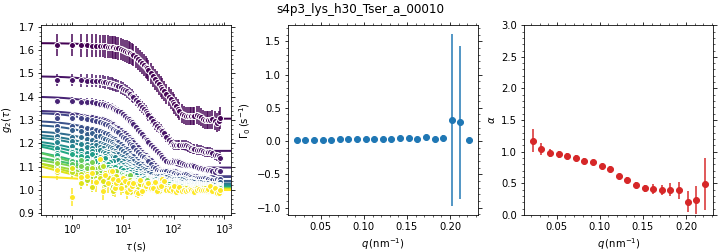

Merged g2 functions:  [0.5] (exposure times)
                      [1] (number of correlation functions)
                      [2000] (total number of images)
Fit successful: True


<IPython.core.display.Javascript object>


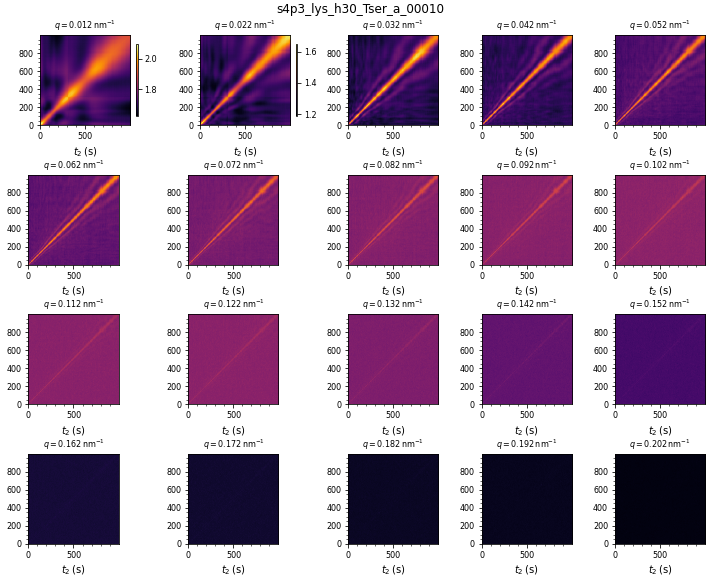

In [124]:
q_min, q_max = 1, None

param, t, qv, g2 = save_g2(ind_xpcs, q_lim=(q_min,q_max), t0_ini=t0_ini, time_lim=0, save=save)# rescale=False)
save_ttcs(ind_xpcs, vmin=None, vmax=None, save=save)

# Save results in h5 file

In [125]:
# g2s
# save result in a dictionary, to then save it in h5 files

#t = g.corrFunc[0][0][1:,0]
#qv = g.corrFunc[0][0][0, q_min+1:q_max]
#g2 = g.corrFunc[0][0][1:, q_min+1:q_max]
#param = g.pars[0]

g2_dict = {
        't' : t,
        'q_values' : qv,
        'g2' : g2,
        'fit_par' : param}
g2_dict.keys()

dict_keys(['t', 'q_values', 'g2', 'fit_par'])

In [126]:
filename = f'{sample}_{run_series:05d}_spot{spot:02d}'

# save g2s fits and curves first
save_dictionary_attr(filename, node='g2s', datasets=g2_dict)

mode is: r+
group already exists! 
in for loop:  t
key:  t
in for loop:  q_values
key:  q_values
in for loop:  g2
key:  g2
in for loop:  fit_par
key:  fit_par


In [100]:
filename

's4p3_lys_h30_Tser_a_00008_spot00'

In [101]:
#!ls ../05-source

In [102]:
# import saved data to check if correct
#filename = 's4p1_lys_h35_300K_c_00001_spot01'
new_dict = import_dictionary_attr(filename)

2d_image 
 <HDF5 group "/2d_image" (1 members)>
	 2d_image/2d_img: 2d_img => <HDF5 dataset "2d_img": shape (2000, 514, 1030), type "<f4">
g2s 
 <HDF5 group "/g2s" (0 members)>
	 g2s/fit_par: fit_par => [[2.19999999e-02 1.67670549e+02 4.68319080e+01 2.43184339e+00
  1.36013598e+00 2.76144596e-01 3.59798354e-02 2.76144596e-01
  3.59798354e-02 1.33470695e+00 2.62365561e-02 8.30547600e+03
  5.99240693e+00 3.15814289e+03 2.71352940e+03]
 [3.20000015e-02 1.04794130e+02 1.65660226e+01 2.50818041e+00
  8.63662013e-01 2.51949271e-01 1.99668696e-02 2.51949271e-01
  1.99668696e-02 1.19713796e+00 1.29898319e-02 8.30547600e+03
  5.99240693e+00 3.15814289e+03 2.71352940e+03]
 [4.19999994e-02 7.91363008e+01 8.22110509e+00 2.48315311e+00
  5.80832567e-01 2.38125533e-01 1.23879574e-02 2.38125533e-01
  1.23879574e-02 1.11243992e+00 7.22989631e-03 8.30547600e+03
  5.99240693e+00 3.15814289e+03 2.71352940e+03]
 [5.20000011e-02 6.38514521e+01 5.71979348e+00 2.38407356e+00
  4.80545739e-01 2.21840055e-01 1.

In [29]:
new_dict.keys()

dict_keys(['2d_image', 'g2s', 'run_info'])

In [103]:
f = h5py.File(f'../05-source/{filename}.h5', 'r')
print(filename)
f.visititems(visit_func)
f.close()

s3p4_lys_h05_300K_a_00002_spot00
/2d_image
	 /2d_image/2d_img (2000, 514, 1030)
/g2s
/run_info


## For TTCs future

In [ ]:
# THIS CELL IS NOT REQUIRED

# Convert the DataFrame to dictionary

dictionaryInstance = dataFrame.to_dict(orient="list")

print("DataFrame as a dictionary(List orientation):")

print(dictionaryInstance)

In [62]:
tmp = d.get_item(ind_xpcs)
ttcs = tmp['twotime_corf'] # list from 0 to 20: len=21
#ttcxy = tmp['twotime_xy'] # shape (5000,)
del tmp
nttcs = len(ttcs.keys()) # 21: number of qs or rois

In [63]:
ttcs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [49]:
np.shape(ttcs[0])

(2000, 2000)

In [77]:
#save_dictionary(filename, node='ttcs6', datasets=ttcs)

**Old saving routine**

In [66]:
g2s_fit = import_h5file('test')

g2s


In [72]:
g2s_fit.keys()
g2s_fit['g2s'].keys()

np.shape(g2s_fit['g2s']['t'])
np.shape(g2s_fit['g2s']['g2'])

(70, 22)

<IPython.core.display.Javascript object>


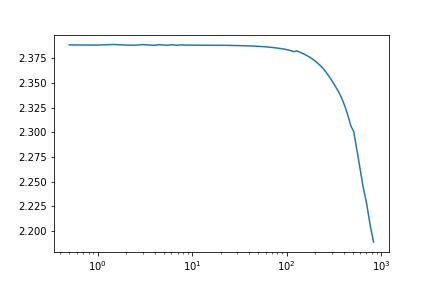

In [73]:
plt.figure()
plt.plot(g2s_fit['g2s']['t'][:-1], g2s_fit['g2s']['g2'][:-1,0])
plt.xscale('log')
plt.show()

# Here old saving method starts

### Save the results

In [27]:
! ls ../05-source/

h0p05.npz			      s17p2_lys_h25_Tser_c_00007_spot00.h5
h0p35.npz			      s17p2_lys_h25_Tser_c_00008_spot00.h5
h0p50.npz			      s17p2_lys_h25_Tser_c_00009_spot00.h5
s17p2_lys_h25_Tser_c_00001_spot00.h5  s17p2_lys_h25_Tser_c_00010_spot00.h5
s17p2_lys_h25_Tser_c_00002_spot00.h5  s17p2_lys_h25_Tser_c_00011_spot00.h5
s17p2_lys_h25_Tser_c_00003_spot00.h5  s17p2_lys_h25_Tser_c_00012_spot00.h5
s17p2_lys_h25_Tser_c_00004_spot00.h5  s17p2_lys_h25_Tser_c_00013_spot00.h5
s17p2_lys_h25_Tser_c_00005_spot00.h5  s17p2_lys_h25_Tser_c_00014_spot00.h5
s17p2_lys_h25_Tser_c_00006_spot00.h5  test.h5


In [28]:
filename = f'{sample}_{run_series:05d}_spot{spot:02d}'
save_results(filename=filename)

### Check the structure of the saved file

In [29]:
f = h5py.File(f'../05-source/{filename}.h5', 'r')
print(filename)
f.visititems(visit_func)
f.close()

s17p2_lys_h25_Tser_c_00013_spot00
/2d_image
	 /2d_image/2d_img (10000, 514, 1030)
/g2s
	 /g2s/g2 (88, 22)
	 /g2s/q_values (22,)
	 /g2s/time (88,)
/run_info
/run_info/detector is an object Dataset
	 /run_info/dt ()
	 /run_info/h_value ()
	 /run_info/n_frames ()
	 /run_info/temperature ()
	 /run_info/transmission ()
/xpcs_analysis
	 /xpcs_analysis/database_id ()
/xpcs_analysis/setup_path is an object Dataset


# Functions to plot g2s and TTCs
Saved in *functions_xpcs.py* script

# For the future: ttc

In [85]:
# -- doesn't work
# ttc
tmp = d.get_item(ind_xpcs)
ttcs = tmp['twotime_corf']
ttcxy = tmp['twotime_xy']
del tmp

g2 = hf.create_group('ttc')
g2.create_dataset('ttcs', data=tmp)
g2.create_dataset('ttcxy', data=ttcxy)

RuntimeError: Unable to create attribute (object header message is too large)

In [58]:
tmp = d.get_item(ind_xpcs)
ttcs = tmp['twotime_corf']
#ttcxy = tmp['twotime_xy']
type(ttcs)

dict

In [69]:
ana = d
tmp = ana.get_item(ind_xpcs)

ttcs = tmp['twotime_corf'] # list from 0 to 20: len=21
ttcxy = tmp['twotime_xy'] # shape (5000,)
del tmp
#ttcs[ind]
#ttcs.keys() # 21: number of qs or rois


In [71]:
ttcs.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [76]:
ar = np.asarray(ttcs)
np.shape(ar)

()

In [ ]:
# group1: g2s
    # g2
    # time
    # q_values
    # fit parameters: database
# group2: ttc
    # ttcs
# group3: static
    # waxs init
    # waxs fin
    # waxs avg

# group4: run info
    # dt, n-frames, h-values, temp, dose, transmission, fast/slow, detector
# group5: miscellanea
    #filename, mask path, setup path, database_index
    
    
    

# -- save results
hf = h5py.File('data.h5', 'w')

g1 = hf.create_group('g2s')
g1.create_dataset('g2', data=...)
g1.create_dataset('time', data=...)
g1.create_dataset('q_values', data=...)
g1.create_dataset('fit', data=...)

g2 = hf.create_group('ttc')
g2.create_dataset('ttc', data=...)

g3 = hf.create_group('static')
g3.create_dataset('waxs_init', data=...)
g3.create_dataset('waxs_fin', data=...)
g3.create_dataset('waxs_avg', data=...)

g4 = hf.create_group('run_info')
g4.create_dataset('dt', data=...)
g4.create_dataset('n_frames', data=...)
g4.create_dataset('h_value', data=...)
g4.create_dataset('temperature', data=...)
g4.create_dataset('transmission', data=...)

g5 = hf.create_group('miscel')
g5.create_dataset('mask_path', data='')

#hf.visititems(visit_func)   
#hf.close()

